# Train MaskRCNN by Detectron2


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Jun 16 07:41:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install detectron2

In [3]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 14.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=b981f4c3a425d67dea24360e61617fdc25bfccf9754acd4b67770ac013f9658a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 4.0MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 112kB 24.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=5808503d9b39af536aeefbee859c8190f5b9e41457cf55eaa2bbcf79ebdd78cf
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=3ae350621b48000cfa069acd7804b03f7bd04145d1929c1823899be981ef1b90
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built fvcore antlr4-python3-runtime


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

In [2]:
!mkdir dataset

In [3]:
!wget https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_4626_514_is.zip
!unzip -q chimei_4626_514_is.zip

--2021-06-16 07:46:04--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_4626_514_is.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356741211 (340M) [application/zip]
Saving to: ‘chimei_4626_514_is.zip’

chimei_4626_514_is. 100%[===================>] 340.21M   462KB/s    in 5m 48s  

2021-06-16 07:51:52 (1002 KB/s) - ‘chimei_4626_514_is.zip’ saved [356741211/356741211]



In [4]:
# !rm chimei_3524_390_is.zip
!mv chimei_4626_514_is/* dataset/
!rm -r __MACOSX
!rm -r chimei_4626_514_is/
%pwd

'/content'

In [5]:
# rename json files if it is necessary
!mv dataset/train/via_region_data_train.json dataset/train/via_region_data.json 
!mv dataset/val/via_region_data_val.json dataset/val/via_region_data.json 

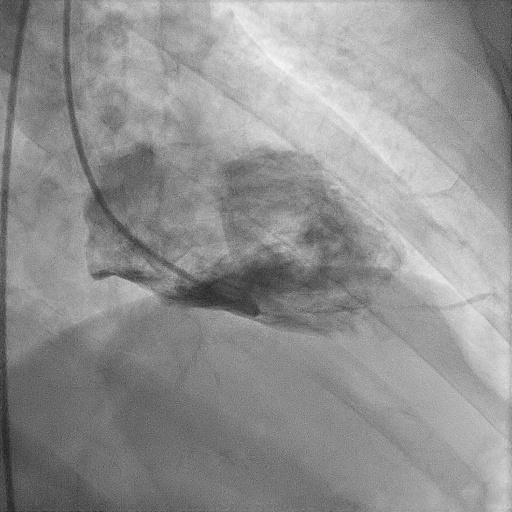

In [6]:
im = cv2.imread("./dataset/train/0001_00036.png")
cv2_imshow(im)

# Train on a custom dataset

## Prepare the dataset
Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. 

**category_id (int, required)**: an integer in the range [0, num_categories-1] representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.

In [7]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            # assert not anno["region_attributes"]
            category_id = int(list(anno["region_attributes"].values())[0])
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("dataset/" + d))
    #MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["heart"])
balloon_metadata = MetadataCatalog.get("balloon_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



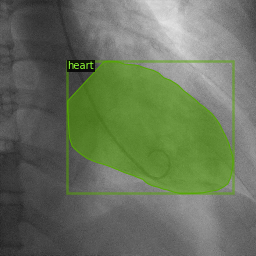

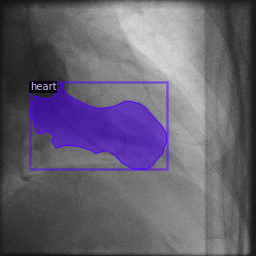

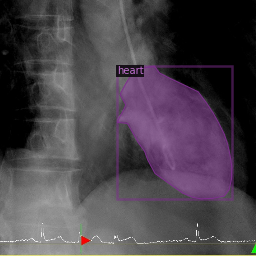

In [8]:
dataset_dicts = get_balloon_dicts("dataset/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
# !rm -r output

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[06/16 07:52:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:17, 10.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

In [ ]:
trainer.train()

[06/10 00:42:44 d2.engine.train_loop]: Starting training from iteration 0
[06/10 00:42:49 d2.utils.events]:  eta: 0:45:26  iter: 19  total_loss: 2.102  loss_cls: 0.8103  loss_box_reg: 0.5713  loss_mask: 0.6912  loss_rpn_cls: 0.02305  loss_rpn_loc: 0.01168  time: 0.2674  data_time: 0.0327  lr: 4.9953e-06  max_mem: 3699M
[06/10 00:42:55 d2.utils.events]:  eta: 0:45:09  iter: 39  total_loss: 1.98  loss_cls: 0.713  loss_box_reg: 0.5599  loss_mask: 0.6899  loss_rpn_cls: 0.01978  loss_rpn_loc: 0.01242  time: 0.2669  data_time: 0.0221  lr: 9.9902e-06  max_mem: 3699M
[06/10 00:43:00 d2.utils.events]:  eta: 0:45:03  iter: 59  total_loss: 1.837  loss_cls: 0.5525  loss_box_reg: 0.5764  loss_mask: 0.6869  loss_rpn_cls: 0.01527  loss_rpn_loc: 0.01147  time: 0.2664  data_time: 0.0221  lr: 1.4985e-05  max_mem: 3699M
[06/10 00:43:05 d2.utils.events]:  eta: 0:44:58  iter: 79  total_loss: 1.722  loss_cls: 0.4333  loss_box_reg: 0.5896  loss_mask: 0.6827  loss_rpn_cls: 0.02026  loss_rpn_loc: 0.01219  time

In [ ]:
# !cp output/* drive/MyDrive/colab_data/chimei/checkpoints/MaskRCNN/

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [109]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join("drive/MyDrive/colab_data/chimei/checkpoints/MaskRCNN/20210610/", "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 #0.5   # set a custom testing threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7 #0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.92 #0.5

cfg.MODEL.RPN.NMS_THRESH = 0.5 #0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3 #0.3
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.3 #0.3

predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

[0.9995204]
ground truth: dataset/val/20483_00085.png


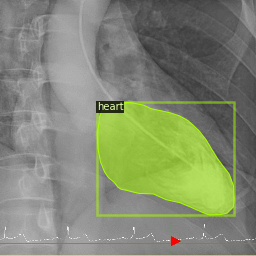

predicted result: dataset/val/20483_00085.png


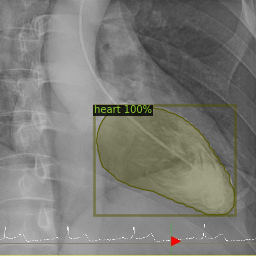

[0.9992163]
ground truth: dataset/val/0004_00067.png


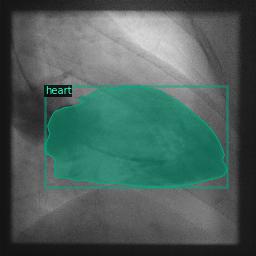

predicted result: dataset/val/0004_00067.png


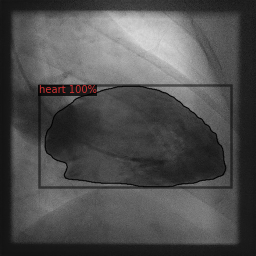

[0.9998529]
ground truth: dataset/val/0722_frames_00084.png


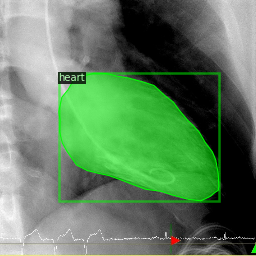

predicted result: dataset/val/0722_frames_00084.png


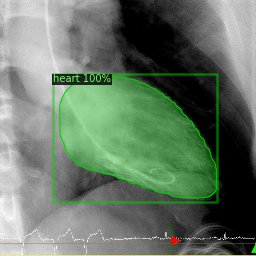

In [76]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("dataset/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    # print(outputs['instances'].get('scores').cpu().numpy())
    # draw ground truth
    visualizer = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    print("ground truth:", d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1])

    # draw predicted result
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, #0.5
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print("predicted result:", d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1])


## Calculate Validation IoU

In [12]:
IoU_total = 0
count = 0

dataset_dicts = get_balloon_dicts("dataset/val")
for d in dataset_dicts:
    # get ground truth mask
    labelImg = Image.new("L", (512,512), 0)
    drawer = ImageDraw.Draw(labelImg)
    drawer.polygon(d['annotations'][0]['segmentation'][0], fill=1)
    gt = np.array(labelImg)
    # print(gt.shape)
    # print(gt)
 
    # get predicted mask  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    # pred_classes = outputs['instances'].get('pred_classes').cpu().numpy()
    masks = outputs['instances'].get('pred_masks').cpu().permute(1, 2, 0).numpy()[:,:,0] # only pick 1 result
    # print(pred_classes)
    masks = masks.squeeze()
    # print(masks.shape)
    # print(masks)

    # calculate IoU of this image
    intersection = np.sum(gt*masks)
    union = np.sum(gt + masks) - intersection
    iou = intersection / union
    
    IoU_total = IoU_total + iou
    count = count + 1

print("Average IoU Score:", IoU_total/count)

Average IoU Score: 0.8941978674630489


## AP metric

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/16 07:53:36 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[06/16 07:53:36 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[06/16 07:53:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/16 07:53:38 d2.data.datasets.coco]: Conversion finished, #images: 514, #annotations: 514
[06/16 07:53:38 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[06/16 07:53:39 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   heart    | 514          |
|            |              |
[06/16 07:53:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/16 07:53:39 d2.data.common]: Serializing 514 elements

# Test dataset

## Download test dataset

In [342]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210111.zip\
    -O chimei_test_20210111.zip

!unzip -q chimei_test_20210111.zip
!rm -r __MACOSX

--2021-06-16 11:49:57--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210111.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75242818 (72M) [application/zip]
Saving to: ‘chimei_test_20210111.zip’

chimei_test_2021011 100%[===================>]  71.76M  1.95MB/s    in 40s     

2021-06-16 11:50:38 (1.78 MB/s) - ‘chimei_test_20210111.zip’ saved [75242818/75242818]



## Util for generating all predicted masks

In [61]:
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import random as rng

def draw_combined_color(mask_image):
    colors = {0:0,      #bg 0
              1:250,    #diastole 1
              -1:100}    #systole -1

    out_image = np.zeros_like(mask_image)

    for k,v in colors.items():
        class_mask = (mask_image==k) # get the layer of class
        class_mask = class_mask * colors[k]
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image
  
def get_enclosing_circle(pr_mask, threshold=100):
    """
    input:
        pr_mask is numpy array with shape (width height)
        threshold max 255 default 100
    outputs:
        enclosing circle center and radius
    """
    colors = [0,      #bg
              250,    #heart
              0]      #unlabel
    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "L", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
        
    img_mask.save("enclosing.jpg")
    # cv2 process from here
    src = cv2.imread("enclosing.jpg")
    src_blur = cv2.blur(src, (3,3))
    # cv2.imwrite("enclosing_blur.jpg", src_blur)
    # Detect edges using Canny
    canny_output = cv2.Canny(src_blur, threshold, threshold * 2)
    # cv2.imwrite("enclosing_canny.jpg", canny_output)
    # Find contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Approximate contours to polygons + get bounding rects and circles
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    # draw result
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    # Draw polygonal contour + bonding rects + circles
    temp_i = 0
    temp_r = 0
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
        # keep the biggest circle for output
        if int(radius[i]) > temp_r:
          temp_r = int(radius[i])
          temp_i = i
    # cv2.imwrite('enclosing_contours.jpg', drawing)
    return int(centers[temp_i][0]), int(centers[temp_i][1]), int(radius[temp_i])

## Select test folder

In [348]:
test_target = "0414"

# !rm -r temp
# !mkdir temp
# !cp dataset/train/20492* temp/
# !cp dataset/val/20492* temp/
# testdata_folder = "temp"

testdata_folder = os.path.join("20210111", test_target, test_target)
# testdata_folder = os.path.join("20210128", test_target, "images")

testdatalist = os.listdir(testdata_folder)
# sort the file name
testdatalist.sort()
total_images = len(testdatalist)
print("total test images:", len(testdatalist))

total test images: 169


## Find the max and min images

In [349]:
# original images dict
test_dict = dict(enumerate(testdatalist))

width = 512
height = 512
# need_resize = False

# count the pixel of heart
heart_max = 0
heart_min = width*height
max_file = str()
min_file = str()
max_key = int()
min_key = int()

# get the max area image
for k,i in enumerate(testdatalist):
    im = cv2.imread(os.path.join(testdata_folder, i))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
      # get the max confident score index
      index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
      # get predicted result
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
      pr_mask = pr_mask.squeeze()
      # count the pixels of heart(label==1)
      heart = np.sum(pr_mask==1)
      if heart > heart_max:
        heart_max = heart
        max_file = i
        max_key = k
    else:
      # get predicted result
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)
      pr_mask = pr_mask.squeeze()
      # count the pixels of heart(label==1)
      heart = np.sum(pr_mask==1)
      if heart > heart_max:
        heart_max = heart
        max_file = i
        max_key = k

# get the min area image, the min image should appear after max image
for k,i in enumerate(testdatalist):
    im = cv2.imread(os.path.join(testdata_folder, i))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
      # get the max confident score index
      index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
      # get predicted result
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
      pr_mask = pr_mask.squeeze()
      # count the pixels of heart(label==1)
      heart = np.sum(pr_mask==1)
      if heart < heart_min and k > max_key and heart != 0:
        heart_min = heart
        min_file = i
        min_key = k
    else:
      # get predicted result
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)
      pr_mask = pr_mask.squeeze()
      # count the pixels of heart(label==1)
      heart = np.sum(pr_mask==1)
      if heart < heart_min and k > max_key and heart != 0:
        heart_min = heart
        min_file = i
        min_key = k

# check the results
print("max_key is:", max_key)
print("min_key is:", min_key)
print("heart_max is:", heart_max)
print("heart_min is:", heart_min)

max_key is: 123
min_key is: 133
heart_max is: 62315
heart_min is: 34032


predicted max result: 00123.jpg


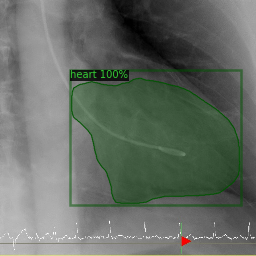

predicted min result: 00133.jpg


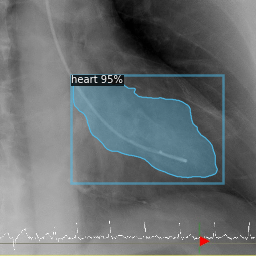

In [350]:
# draw the max image
im = cv2.imread(os.path.join(testdata_folder, max_file))
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
  # get the max confident score index
  index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
  v = Visualizer(im[:, :, ::-1],
                    metadata=balloon_metadata, 
                    scale=0.5, #0.5
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  print("predicted max result:", max_file)
  cv2_imshow(out.get_image()[:, :, ::-1])
  ### save mask for later combined image use
  pr_mask_max = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
  pr_mask_max = pr_mask_max.squeeze()

else:
  # draw predicted result
  v = Visualizer(im[:, :, ::-1],
                    metadata=balloon_metadata, 
                    scale=0.5, #0.5
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  print("predicted max result:", max_file)
  cv2_imshow(out.get_image()[:, :, ::-1])
  ### save mask for later combined image use
  pr_mask_max = np.asarray(outputs["instances"].to("cpu").pred_masks)
  pr_mask_max = pr_mask_max.squeeze()

# draw the min image
im = cv2.imread(os.path.join(testdata_folder, min_file))
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
  # get the max confident score index
  index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
  # draw predicted result
  v = Visualizer(im[:, :, ::-1],
                    metadata=balloon_metadata, 
                    scale=0.5, #0.5
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  print("predicted min result:", min_file)
  cv2_imshow(out.get_image()[:, :, ::-1])
  ### save mask for later combined image use
  pr_mask_min = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
  pr_mask_min = pr_mask_min.squeeze()
else:
  # draw predicted result
  v = Visualizer(im[:, :, ::-1],
                    metadata=balloon_metadata, 
                    scale=0.5, #0.5
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  print("predicted min result:", min_file)
  cv2_imshow(out.get_image()[:, :, ::-1])
  ### save mask for later combined image use
  pr_mask_min = np.asarray(outputs["instances"].to("cpu").pred_masks)
  pr_mask_min = pr_mask_min.squeeze()

## Calculate EF by using average area and L

In [351]:
# set parameters
average_count = 5
max_area_list = []
min_area_list = []
max_L_list = []
min_L_list = []

# get the max list
for i in range(average_count):
  if max_key+i-(average_count-1)/2 >= 0 and max_key+i-(average_count-1)/2 < total_images:
    im = cv2.imread(os.path.join(testdata_folder, test_dict[max_key+i-(average_count-1)/2]))
    outputs = predictor(im)

    if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
      # get the max confident score index
      index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
      pr_mask = pr_mask.squeeze()
      # make sure the value is not too different from the original one
      if abs(heart_max - np.sum(pr_mask==1)) < heart_max*0.2:
        max_area_list.append(np.sum(pr_mask==1))
        _, _, r_max = get_enclosing_circle(pr_mask)
        max_L_list.append(2*r_max)
    else:
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)
      pr_mask = pr_mask.squeeze()
      # make sure the value is not too different from the original one
      if abs(heart_max - np.sum(pr_mask==1)) < heart_max*0.2:
        max_area_list.append(np.sum(pr_mask==1))
        _, _, r_max = get_enclosing_circle(pr_mask)
        max_L_list.append(2*r_max)

# get the min list
for i in range(average_count):
  # if test_dict.get(min_key+i-(average_count-1)/2,0) != 0:
  if min_key+i-(average_count-1)/2 >= 0 and min_key+i-(average_count-1)/2 < total_images:
    im = cv2.imread(os.path.join(testdata_folder, test_dict[min_key+i-(average_count-1)/2]))
    outputs = predictor(im)

    if len(outputs['instances'].get('scores').cpu().numpy()) > 1:
      # get the max confident score index
      index = np.argmax(outputs['instances'].get('scores').cpu().numpy())
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)[index]
      pr_mask = pr_mask.squeeze()
      # make sure the value is not too different from the original one
      if abs(heart_min - np.sum(pr_mask==1)) < heart_min*0.2:
        min_area_list.append(np.sum(pr_mask==1))
        _, _, r_min = get_enclosing_circle(pr_mask)
        min_L_list.append(2*r_min)

    else:
      pr_mask = np.asarray(outputs["instances"].to("cpu").pred_masks)
      pr_mask = pr_mask.squeeze()
      # make sure the value is not too different from the original one
      if abs(heart_min - np.sum(pr_mask==1)) < heart_min*0.2:
        min_area_list.append(np.sum(pr_mask==1))
        _, _, r_min = get_enclosing_circle(pr_mask)
        min_L_list.append(2*r_min)

# print results
print("the max area is:", max_area_list)
print("the min area is:", min_area_list)
print("the L of max area is:", max_L_list)
print("the L of min area is:", min_L_list)

heart_max = sum(max_area_list) / len(max_area_list)
heart_min = sum(min_area_list) / len(min_area_list)
L_max = sum(max_L_list) / len(max_L_list)
L_min = sum(min_L_list) / len(min_L_list)

print("EF((EDV-ESV)/EDV):", 
      round((heart_max**2/L_max - heart_min**2/L_min)/(heart_max**2/L_max),2)*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


the max area is: [55427, 55427, 62315, 62315, 53386]
the min area is: [34032, 34032]
the L of max area is: [354, 354, 372, 372, 330]
the L of min area is: [336, 336]
EF((EDV-ESV)/EDV): 63.0


## Draw the combined image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: 0414_combined.png is a low contrast image


{-1: 34032, 0: 228112}
{0: 199829, 1: 62315}
{-1: 744, 0: 232373, 1: 29027}


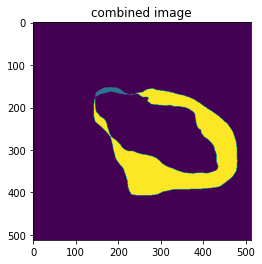

In [352]:
# min image process
pr_mask_min_t = pr_mask_min * -1 # make the systole label as -1 for later calculation
unique, counts = np.unique(pr_mask_min_t, return_counts=True)
print(dict(zip(unique, counts)))

# max image process
pr_mask_max_t = pr_mask_max * 1
unique, counts = np.unique(pr_mask_max_t, return_counts=True)
print(dict(zip(unique, counts)))

# combine two images
pr_mask_combined = pr_mask_min_t + pr_mask_max_t
unique, counts = np.unique(pr_mask_combined, return_counts=True)
print(dict(zip(unique, counts)))

# draw the image
pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
io.imsave(test_target + "_combined.png", pr_mask_combined_draw)
plt.title('combined image')
plt.imshow(pr_mask_combined_draw)

Reference:  
https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html  
https://github.com/facebookresearch/detectron2  